In [94]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt, seaborn as sns
import folium 
from sklearn.metrics.pairwise import (cosine_similarity, euclidean_distances, manhattan_distances) 
from IPython.display import display
from surprise import SVD, Dataset, NormalPredictor, Reader, accuracy, KNNBasic, evaluate, BaselineOnly
from surprise import get_dataset_dir
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV, KFold
from collections import defaultdict


%matplotlib inline

In [68]:
!pip install folium

# EDA 

### Read Business Dataset

In [2]:
business = pd.read_csv('../yelp_academic_dataset/yelp_business.csv')

In [3]:
business.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...


### Dataset Includes ~175,000 Businesses

In [4]:
business.shape

(174567, 13)

### The Dataset includes 68 'State' values, I decided to look at only 'States' with more than 200 businesses

In [5]:
states = business['state'].value_counts()[business['state'].value_counts() > 200]

In [6]:
states = pd.DataFrame({'state':states.index, 'count':states.values})

In [7]:
states

,count,state
0,52214,AZ
1,33086,NV
2,30208,ON
3,12956,NC
4,12609,OH
5,10109,PA
6,8169,QC
7,4754,WI
8,3795,EDH
9,3118,BW


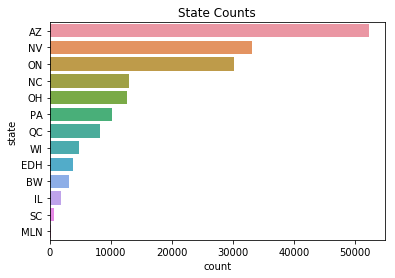

In [8]:
sns.barplot(x='count', y='state', data=states)
plt.title("State Counts");

### The Dataset includes ~1000 'City' values, I decided to look at only cities with more than 1000 businesses

In [9]:
cities = business['city'].value_counts()[business['city'].value_counts() > 1000]

In [10]:
cities = pd.DataFrame({'city':cities.index, 'count':cities.values})
cities

,city,count
0,Las Vegas,26775
1,Phoenix,17213
2,Toronto,17206
3,Charlotte,8553
4,Scottsdale,8228
5,Pittsburgh,6355
6,Mesa,5760
7,Montréal,5709
8,Henderson,4465
9,Tempe,4263


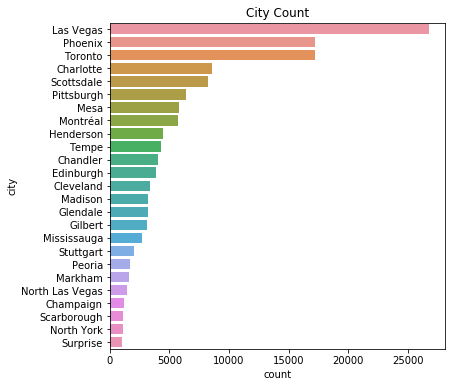

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='count', y='city', data=cities, ax=ax)
plt.title("City Count");

### Mask Business Dataset to Test Workability
#### First Use 'Las Vegas' (Largest Market) &  > 1000 reviews  (to improve matches between users)

In [12]:
business = business[(business['city'] == 'Las Vegas') & (business['review_count'] > 1000)]

In [13]:
business.shape

(186, 13)

In [14]:
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
800,o7AiTlyWUrBSzdz6oMHj5w,"""Excalibur Hotel""",The Strip,"""Excalibur Hotel And Casino, 3850 Las Vegas Bl...",Las Vegas,NV,89109,36.098732,-115.174726,2.5,2504,1,Hotels;Event Planning & Services;Casinos;Resor...
801,PgJgpW4TKQ8IoALH2Yq-zA,"""Bayside Buffet at Mandalay Bay""",The Strip,"""3950 S Las Vegas Blvd""",Las Vegas,NV,89109,36.091219,-115.175804,3.0,1033,1,Arts & Entertainment;Restaurants;Buffets;Ameri...
2803,5iSmZO0SrKU6EoXK_1M8Kw,"""Monte Carlo Hotel And Casino""",The Strip,"""3770 Las Vegas Blvd S""",Las Vegas,NV,89109,36.104614,-115.176021,2.5,2507,1,Resorts;Hotels & Travel;Event Planning & Servi...
4416,OVTZNSkSfbl3gVB9XQIJfw,"""Cravings Buffet""",The Strip,"""3400 Las Vegas Blvd S""",Las Vegas,NV,89109,36.121237,-115.174105,3.0,1252,1,American (Traditional);Buffets;Restaurants;Ame...
4439,JDZ6_yycNQFTpUZzLIKHUg,"""El Dorado Cantina""",NaN,"""3025 Sammy Davis Jr Dr""",Las Vegas,NV,89109,36.134915,-115.175822,4.0,1694,1,Lounges;Mexican;Restaurants;Bars;Nightlife


### Truncate Business Columns

In [15]:
business_trunc = business[['business_id', 'name', 'city', 'state', 'review_count']]

In [16]:
business_trunc.head(5)

,business_id,name,city,state,review_count
800,o7AiTlyWUrBSzdz6oMHj5w,"""Excalibur Hotel""",Las Vegas,NV,2504
801,PgJgpW4TKQ8IoALH2Yq-zA,"""Bayside Buffet at Mandalay Bay""",Las Vegas,NV,1033
2803,5iSmZO0SrKU6EoXK_1M8Kw,"""Monte Carlo Hotel And Casino""",Las Vegas,NV,2507
4416,OVTZNSkSfbl3gVB9XQIJfw,"""Cravings Buffet""",Las Vegas,NV,1252
4439,JDZ6_yycNQFTpUZzLIKHUg,"""El Dorado Cantina""",Las Vegas,NV,1694


### Read User Dataset

In [17]:
user = pd.read_csv('../yelp_academic_dataset/yelp_user.csv')

In [18]:
user.head(2)

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


### Dataset Includes ~1.3 million users

In [19]:
user.shape

(1326100, 22)

### User Review Count is heavily skewed left, this makes logical since most users are known to write reviews infrequently

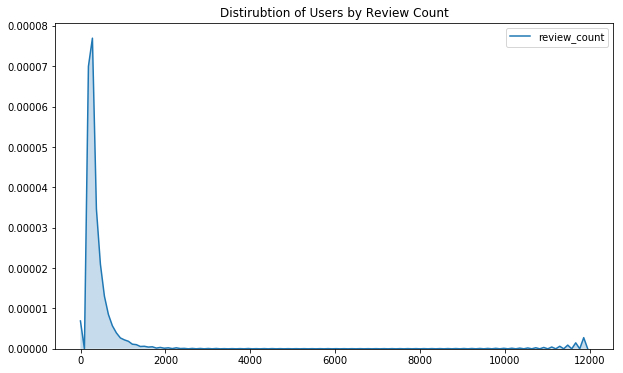

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(user['review_count'], shade=True, ax=ax)
plt.title('Distirubtion of Users by Review Count');

### Individual Review scarcity is one of the inherent challenges for collaborative filtering with this dataset

In [21]:
pd.DataFrame(user['review_count'].describe())

,review_count
count,1.326100e+06
mean,2.311717e+01
std,7.909808e+01
min,0.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.500000e+01
max,1.195400e+04


### Mask User Dataset to Test Workability
#### First Power Users w/ ' > 500' Reviews (to improve matches between businesses)

In [22]:
user = user[user['review_count'] > 500]

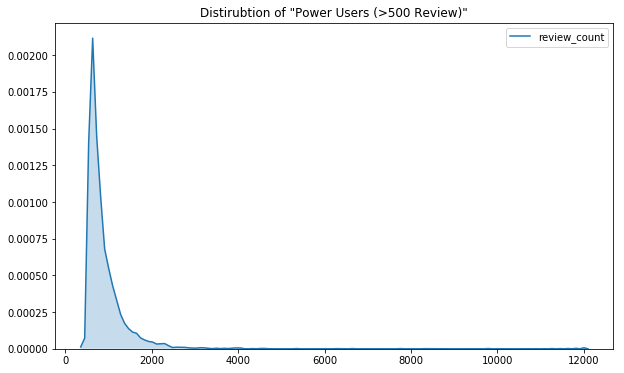

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(user['review_count'], shade=True, ax=ax)
plt.title('Distirubtion of "Power Users (>500 Review)"');

In [24]:
user['user_id'].value_counts().sum()

5903

### Truncate User Columns

In [25]:
user_trunc = user[['user_id', 'review_count']]

In [26]:
user_trunc.head()

,user_id,review_count
74,aw973Pm1nrTbRjP4zY9B9g,762
212,wm97KC6G0resSDXTmNIMKw,1262
730,oH9K7eCuNsYr6MmlM2ZjUg,902
756,bzMzZE3OCqHhZyXH5JRaWw,851
794,lmJy4OwP_TyHIg8a8Q0RsA,646


In [27]:
user_trunc.shape

(5903, 2)

### Read Review Dataset
#### This Dataset includes ~ 5.2 million reviews

In [28]:
reviews = pd.read_csv('../yelp_academic_dataset/yelp_review.csv')

In [29]:
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [30]:
reviews.shape

(5261668, 9)

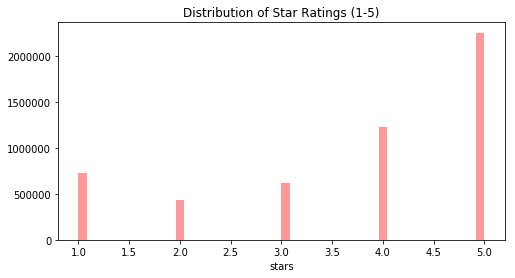

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(reviews['stars'], kde=False, color='red', ax=ax)
plt.title("Distribution of Star Ratings (1-5)");

### Review Rating Distribution is Skewed to the Right

In [32]:
pd.DataFrame(reviews['stars'].describe())

,stars
count,5.261668e+06
mean,3.727739e+00
std,1.433593e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Truncate Review Columns

In [33]:
reviews_trunc = reviews[['review_id', 'user_id', 'business_id','stars']]

In [34]:
reviews_trunc.head(10)

,review_id,user_id,business_id,stars
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4
5,HRPm3vEZ_F-33TYVT7Pebw,_4iMDXbXZ1p1ONG297YEAQ,8QWPlVQ6D-OExqXoaD2Z1g,5
6,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg,9_CGhHMz8698M9-PkVf0CQ,4
7,8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4
8,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3
9,WF_QTN3p-thD74hqpp2j-Q,u0LXt3Uea_GidxRW1xcsfg,fDF_o2JPU8BR1Gya--jRIA,5


### Merge Datasets so that Masks create a limited a single DataFrame

In [35]:
df = reviews_trunc.merge(user_trunc, how='inner', on='user_id').merge(business_trunc, how='inner', on='business_id')

In [36]:
df.shape

(31908, 9)

### Drop Columns not needed for Model

In [37]:
df.drop(['review_id','review_count_x', 'name', 'city', 'state', 'review_count_y'], axis=1, inplace=True)

In [38]:
df.head()

,user_id,business_id,stars
0,tL2pS5UOmN6aAOi3Z-qFGg,eAc9Vd6loOgRQolMXQt6FA,4
1,3wB-JjsUjkvdNUDRnChsVg,eAc9Vd6loOgRQolMXQt6FA,4
2,3EAHMMsNnN4rrQVPPuzdnw,eAc9Vd6loOgRQolMXQt6FA,3
3,m8nDqQ7a3zQWfkNK1_vwnQ,eAc9Vd6loOgRQolMXQt6FA,4
4,-hxUwfo3cMnLTv-CAaP69A,eAc9Vd6loOgRQolMXQt6FA,4


In [39]:
df.shape

(31908, 3)

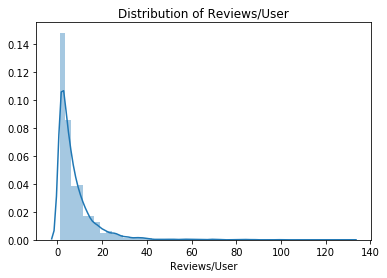

In [40]:
sns.distplot(df['user_id'].value_counts(), axlabel='Reviews/User')
plt.title("Distribution of Reviews/User");

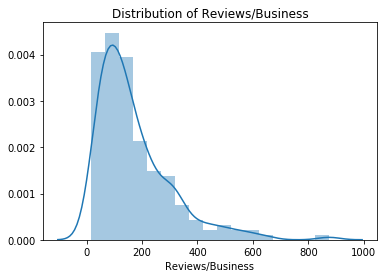

In [41]:
sns.distplot(df['business_id'].value_counts(), axlabel='Reviews/Business')
plt.title("Distribution of Reviews/Business");

#### Set Minimum # of User Reviews to Be Included

In [42]:
df = df.groupby('user_id').filter(lambda group: len(group) > 10)

#### Set Minimum # of Business Reviews to Be Included

In [231]:
df = df.groupby('business_id').filter(lambda group: len(group) > 20)

### DataFrame Descrptition  

In [44]:
print("\n")
print("Number of reviews included: %s " %df.shape[0])
print("")
print("Number of unique users included: %s" %df['user_id'].unique().size)
print("")
print("Number of unique businesses included: %s" %df['business_id'].unique().size)
print("\n")



Number of reviews included: 18764 

Number of unique users included: 928

Number of unique businesses included: 182




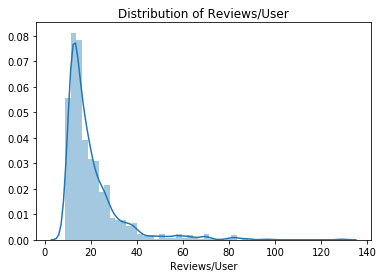

In [45]:
sns.distplot(df['user_id'].value_counts(), axlabel='Reviews/User')
plt.title("Distribution of Reviews/User");

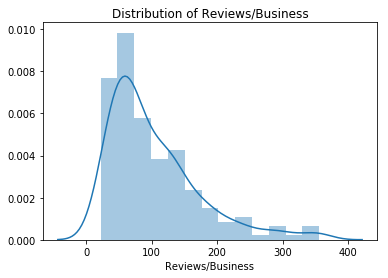

In [46]:
sns.distplot(df['business_id'].value_counts(), axlabel='Reviews/Business')
plt.title("Distribution of Reviews/Business");

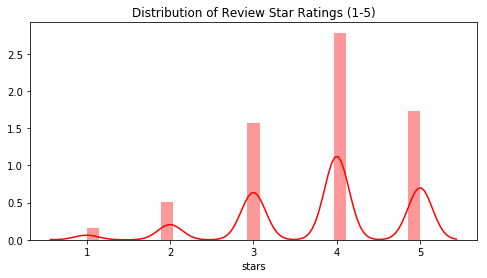

In [47]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(df['stars'], kde=True, color='red', ax=ax)
plt.title("Distribution of Review Star Ratings (1-5)");

In [48]:
pd.DataFrame(df['stars'].describe())

,stars
count,18764.000000
mean,3.805052
std,0.977792
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


## Create/Test Models Using Surprise Package

In [178]:

# Create Reader w/ Scale to Import DataFrame into Surprise
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['user_id', 'business_id', 'stars']], reader)

# Establish Baseline Scoring for Model 
# Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
algo = NormalPredictor()
#algo = BaselineOnly()

# Use Train_Test_Split on data
trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
random_predictions = algo.test(testset)

# Then compute RMSE & MAE for Random 
print("Baseline Scores using Random Ratings")
print(accuracy.rmse(random_predictions))
print(accuracy.mae(random_predictions))

Baseline Scores using Random Ratings
RMSE: 1.3259
1.325939148711903
MAE:  1.0548
1.0547845734659433


In [222]:
# Define Algorithm for Model

# algo = sim_options = {'name': 'cosine',
#                 'user_based': True  # compute  similarities between items
#                 }

algo = sim_options = {'name': 'msd',
#                'user_based': True  # compute  similarities between items
                }

algo = KNNBasic(sim_options=sim_options)

#algo = SVD()

# Use Train_Test_Split on data
trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE & MAE
print("Accuracy Score Using Fitted Model")
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
Accuracy Score Using Fitted Model
RMSE: 0.8956
0.8956319433607344
MAE:  0.7027
0.70273306066544


In [214]:
print(predictions[1])
print(predictions[2])
print(predictions[3])

user: swocJWD8R1iH20-lveXh0Q item: WYw3Uf56DT5IwpaLNnCH5Q r_ui = 3.00   est = 4.08   {'actual_k': 40, 'was_impossible': False}
user: HaoPeg2ySVEbQKN3gySxHQ item: OVTZNSkSfbl3gVB9XQIJfw r_ui = 3.00   est = 3.23   {'actual_k': 40, 'was_impossible': False}
user: xoNpQ_DnzNuTbkFPPO0Lgw item: aT_SsfZ6GQgJGyuIv1Hapw r_ui = 4.00   est = 4.13   {'actual_k': 40, 'was_impossible': False}


## Create Function to Rank Top Predictions(Recommended Businesses) / User

In [223]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = sim_options = {'name': 'msd',
#                 'user_based': True  # compute  similarities between items 
                }
    
algo = KNNBasic(sim_options=sim_options)

#algo = SVD()
               
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

#predictions

top_n = get_top_n(predictions, n=3)

#create dataframe with top 3 recommendations by user with estimated scores and business_ids

top_3df = pd.DataFrame(list(top_n.items()), columns=['user_id', 'recos'])
top_3df[['Reco_1','Reco_2', 'Reco_3']] = pd.DataFrame(top_3df.recos.values.tolist(), index= top_3df.index)
top_3df.drop(['recos'], axis=1, inplace=True)
top_3df[['1st Recommendation', '1st Est Rating']] = top_3df['Reco_1'].apply(pd.Series)
top_3df[['2nd Recommendation', '2nd Est Rating']] = top_3df['Reco_2'].apply(pd.Series)
top_3df[['3rd Recommendation', '3rd Est Rating']] = top_3df['Reco_3'].apply(pd.Series)
top_3df.drop(['Reco_1', 'Reco_2', 'Reco_3'], axis=1, inplace=True)
top_3df.head()

Computing the msd similarity matrix...
Done computing similarity matrix.


,user_id,1st Recommendation,1st Est Rating,2nd Recommendation,2nd Est Rating,3rd Recommendation,3rd Est Rating
0,tL2pS5UOmN6aAOi3Z-qFGg,NCFwm2-TDb-oBQ2medmYDg,4.653067,IhNASEZ3XnBHmuuVnWdIwA,4.607285,BH9z7IJ4zydAqgwsbqoVZQ,4.563947
1,3wB-JjsUjkvdNUDRnChsVg,NCFwm2-TDb-oBQ2medmYDg,4.692546,A-uZAD4zP3rRxb44WUGV5w,4.513890,ty5KQYqYRxwXDG_e4pz-4w,4.470661
2,-hxUwfo3cMnLTv-CAaP69A,NCFwm2-TDb-oBQ2medmYDg,4.844975,A-uZAD4zP3rRxb44WUGV5w,4.556600,ty5KQYqYRxwXDG_e4pz-4w,4.551289
3,EE9txZm_zUFqWeYGVGaFNg,NCFwm2-TDb-oBQ2medmYDg,4.824393,ty5KQYqYRxwXDG_e4pz-4w,4.693717,A-uZAD4zP3rRxb44WUGV5w,4.561022
4,ZbkA2bI3HGqQmy_z-YWAmg,NCFwm2-TDb-oBQ2medmYDg,4.770202,IhNASEZ3XnBHmuuVnWdIwA,4.632974,BH9z7IJ4zydAqgwsbqoVZQ,4.626882


## Create List of Available User_Ids w/ Names and Meta Data

In [224]:
top_3df = top_3df.merge(user, how='inner', on='user_id')
top_3df.drop(['yelping_since', 'friends', 'useful', 'funny', 'cool',
       'fans', 'elite', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'], axis=1)
top_3df = top_3df[['user_id', 'name', '1st Recommendation','1st Est Rating', '2nd Recommendation', '2nd Est Rating', '3rd Recommendation', '3rd Est Rating', 'review_count']]
top_3df.head()

,user_id,name,1st Recommendation,1st Est Rating,2nd Recommendation,2nd Est Rating,3rd Recommendation,3rd Est Rating,review_count
0,tL2pS5UOmN6aAOi3Z-qFGg,Mark,NCFwm2-TDb-oBQ2medmYDg,4.653067,IhNASEZ3XnBHmuuVnWdIwA,4.607285,BH9z7IJ4zydAqgwsbqoVZQ,4.563947,646
1,3wB-JjsUjkvdNUDRnChsVg,Brandon,NCFwm2-TDb-oBQ2medmYDg,4.692546,A-uZAD4zP3rRxb44WUGV5w,4.513890,ty5KQYqYRxwXDG_e4pz-4w,4.470661,1160
2,-hxUwfo3cMnLTv-CAaP69A,Crissy,NCFwm2-TDb-oBQ2medmYDg,4.844975,A-uZAD4zP3rRxb44WUGV5w,4.556600,ty5KQYqYRxwXDG_e4pz-4w,4.551289,676
3,EE9txZm_zUFqWeYGVGaFNg,Wes,NCFwm2-TDb-oBQ2medmYDg,4.824393,ty5KQYqYRxwXDG_e4pz-4w,4.693717,A-uZAD4zP3rRxb44WUGV5w,4.561022,822
4,ZbkA2bI3HGqQmy_z-YWAmg,Romeo,NCFwm2-TDb-oBQ2medmYDg,4.770202,IhNASEZ3XnBHmuuVnWdIwA,4.632974,BH9z7IJ4zydAqgwsbqoVZQ,4.626882,508


In [225]:
user_list = df['user_id'].unique().tolist()
user_list[:10]

['tL2pS5UOmN6aAOi3Z-qFGg',
 '3wB-JjsUjkvdNUDRnChsVg',
 '-hxUwfo3cMnLTv-CAaP69A',
 'EE9txZm_zUFqWeYGVGaFNg',
 'ZbkA2bI3HGqQmy_z-YWAmg',
 'BTsyCC8AmftuDQCDTqBDAw',
 'Vkj42md-5O3VoOD9pBg6Sw',
 '3SGQKsO1J-jcRIp3WNxCeA',
 'YMgZqBUAddmFErxLtCfK_w',
 'cST8Zaw_m73cMYPYA1m1cA']

In [226]:
def new_user_recommendations(user):
    
    # Createe User_Recommendations Dataframe merged with Business Metadata
    
    user_recommendations = top_3df.query("user_id == '"+user+"'")
    user_recommendations = user_recommendations.T.reset_index()
    user_recommendations.columns = ['Info', 'business_id']
    user_recommendations = user_recommendations.merge(business, how='inner', on='business_id')
    user_recommendations.drop(['is_open'], axis=1, inplace=True)
    
    return user_recommendations

In [238]:
new_user_recommendations('EE9txZm_zUFqWeYGVGaFNg')

,Info,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,categories
0,1st Recommendation,NCFwm2-TDb-oBQ2medmYDg,"""Fountains of Bellagio""",The Strip,"""3600 S Las Vegas Blvd""",Las Vegas,NV,89109,36.112986,-115.174078,4.5,1109,Landmarks & Historical Buildings;Public Servic...
1,2nd Recommendation,ty5KQYqYRxwXDG_e4pz-4w,"""Absinthe""",The Strip,"""Flamingo Rd""",Las Vegas,NV,89109,36.113965,-115.174348,4.5,1539,Arts & Entertainment;Performing Arts
2,3rd Recommendation,A-uZAD4zP3rRxb44WUGV5w,"""Soho Japanese Restaurant""",Southwest,"""7377 S Jones Blvd, Ste 116""",Las Vegas,NV,89139,36.055244,-115.225870,4.5,1289,Restaurants;Sushi Bars;Asian Fusion;Japanese


In [239]:
df[df['business_id'] == 'NCFwm2-TDb-oBQ2medmYDg']['stars'].describe()

count    162.000000
mean       4.716049
std        0.551330
min        3.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: stars, dtype: float64

In [228]:
user_id = algo.trainset.to_inner_uid('EE9txZm_zUFqWeYGVGaFNg')

neighbors = algo.get_neighbors(user_id, k=3)
user_neighbors = list(algo.trainset.to_raw_uid(inner_id) for inner_id in neighbors)
user_neighbors = pd.Series(user_neighbors)
user_neighbors = pd.DataFrame(user_neighbors, columns=['user_id'])
user_neighbors.merge(user, how='inner', on='user_id')

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,zwhty_ZmxbHAHoDfMjNbag,Karen,503,2007-08-04,"c0kGm05-YW94DDE-LsD51g, FwgLOzXz5PAwVTMCr-hOBw...",11,19,3,22,"2013, 2017, 2011, 2014, 2016, 2015, 2012",...,0,3,2,0,15,38,59,59,43,14
1,YE54kKTuqJJPNYWIKIpOEQ,Steve,732,2011-04-14,"7082TB0-OSV4JGHOpO6kXA, uLHC1AanJyoa4DB5Z9c6Zg...",41,33,9,8,"2016, 2017, 2015",...,1,1,0,0,11,12,0,0,2,0
2,IVTJIQEWwgZZBZjVtguJDQ,Toma,1005,2008-03-11,"lXR4qM5a1sbq3LTjA2y_1A, gNf5u6gUxiCAWWxLr7uKIQ...",58,7,5,15,None,...,4,1,3,0,15,14,5,5,4,4


In [229]:
def new_user_previously_rated(user):
    
    # Show users previously rated businesses from Dataframe merged with Business Metadata
    
    previously_rated = df[df['user_id'] == user]
    previously_rated = previously_rated.merge(business, how='inner', on='business_id')
    previously_rated = previously_rated.rename({'stars_x': 'user rating'})
    previously_rated.rename(columns = {'stars_x':'user rating', 'stars_y': 'business rating'}, inplace = True)
    previously_rated.drop(['business_id', 'is_open', 'address', 'postal_code'], axis=1, inplace=True)
    
    return previously_rated

In [230]:
# Test User

new_user_previously_rated('EE9txZm_zUFqWeYGVGaFNg')

,user_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,EE9txZm_zUFqWeYGVGaFNg,5,"""Mandalay Bay Resort & Casino""",The Strip,Las Vegas,NV,36.091895,-115.175256,3.5,2687,Casinos;Hotels;Hotels & Travel;Resorts;Arts & ...
1,EE9txZm_zUFqWeYGVGaFNg,3,"""The Peppermill Restaurant & Fireside Lounge""",The Strip,Las Vegas,NV,36.133667,-115.163095,4.0,2703,Bars;American (Traditional);Lounges;Nightlife;...
2,EE9txZm_zUFqWeYGVGaFNg,4,"""Ellis Island Hotel, Casino & Brewery""",Eastside,Las Vegas,NV,36.113025,-115.163485,4.0,1946,Bars;Barbeque;Karaoke;Food;Breweries;Restauran...
3,EE9txZm_zUFqWeYGVGaFNg,5,"""Hash House A Go Go""",Westside,Las Vegas,NV,36.144667,-115.239955,4.0,3050,Restaurants;Breakfast & Brunch;American (New)
4,EE9txZm_zUFqWeYGVGaFNg,5,"""Cirque du Soleil - Zumanity""",The Strip,Las Vegas,NV,36.102894,-115.174842,4.0,1294,Nightlife;Adult Entertainment;Performing Arts;...
5,EE9txZm_zUFqWeYGVGaFNg,5,"""Wynn Las Vegas""",The Strip,Las Vegas,NV,36.127684,-115.165905,4.0,2441,Casinos;Event Planning & Services;Nightlife;Re...
6,EE9txZm_zUFqWeYGVGaFNg,3,"""Shake Shack""",The Strip,Las Vegas,NV,36.103061,-115.173450,4.0,2549,Burgers;American (New);Restaurants
7,EE9txZm_zUFqWeYGVGaFNg,4,"""McCarran International Airport""",Southeast,Las Vegas,NV,36.085016,-115.151009,3.5,3284,Hotels & Travel;Airports
8,EE9txZm_zUFqWeYGVGaFNg,4,"""Burger Bar""",The Strip,Las Vegas,NV,36.094460,-115.176113,4.0,2440,Bars;American (Traditional);Burgers;American (...
9,EE9txZm_zUFqWeYGVGaFNg,4,"""Fremont Street Experience""",Downtown,Las Vegas,NV,36.169182,-115.141881,3.5,1311,Local Flavor;Casinos;Bars;Nightlife;Arts & Ent...


In [167]:
# Neighbor 1

new_user_previously_rated('-hxUwfo3cMnLTv-CAaP69A')

,user_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,-hxUwfo3cMnLTv-CAaP69A,4,"""Mandalay Bay Resort & Casino""",The Strip,Las Vegas,NV,36.091895,-115.175256,3.5,2687,Casinos;Hotels;Hotels & Travel;Resorts;Arts & ...
1,-hxUwfo3cMnLTv-CAaP69A,4,"""LAVO Italian Restaurant & Lounge""",The Strip,Las Vegas,NV,36.124434,-115.169069,3.5,1474,Restaurants;Dance Clubs;Lounges;Nightlife;Ital...
2,-hxUwfo3cMnLTv-CAaP69A,3,"""BLT Burger""",The Strip,Las Vegas,NV,36.120245,-115.173390,3.5,1061,Restaurants;Burgers
3,-hxUwfo3cMnLTv-CAaP69A,5,"""Holsteins Shakes and Buns""",The Strip,Las Vegas,NV,36.109842,-115.174603,4.0,2771,American (Traditional);Burgers;Bars;Restaurant...
4,-hxUwfo3cMnLTv-CAaP69A,5,"""Carson Kitchen""",Downtown,Las Vegas,NV,36.167878,-115.140640,4.5,1586,Salad;Comfort Food;Gastropubs;Nightlife;Cockta...
5,-hxUwfo3cMnLTv-CAaP69A,4,"""Julian Serrano Tapas""",The Strip,Las Vegas,NV,36.108331,-115.175808,4.0,1628,Spanish;Tapas Bars;Restaurants
6,-hxUwfo3cMnLTv-CAaP69A,5,"""Jean Philippe Patisserie""",The Strip,Las Vegas,NV,36.107727,-115.176986,4.0,1301,Specialty Food;Chocolatiers & Shops;Food;Desse...
7,-hxUwfo3cMnLTv-CAaP69A,3,"""Bouchon Bakery at the Venetian Casino""",The Strip,Las Vegas,NV,36.121774,-115.169229,4.0,1032,Restaurants;Bakeries;Macarons;Specialty Food;F...
8,-hxUwfo3cMnLTv-CAaP69A,5,"""The Signature at MGM Grand""",Eastside,Las Vegas,NV,36.106254,-115.166586,4.0,1509,Hotels;Home Services;Hotels & Travel;Event Pla...
9,-hxUwfo3cMnLTv-CAaP69A,5,"""Cirque du Soleil - The Beatles LOVE""",The Strip,Las Vegas,NV,36.121324,-115.174956,4.5,1842,Arts & Entertainment;Performing Arts


In [168]:
# Neighbor 2

new_user_previously_rated('R3jMcisnWU-gjjSXgWNXvw')

,user_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,R3jMcisnWU-gjjSXgWNXvw,3,"""Mandalay Bay Resort & Casino""",The Strip,Las Vegas,NV,36.091895,-115.175256,3.5,2687,Casinos;Hotels;Hotels & Travel;Resorts;Arts & ...
1,R3jMcisnWU-gjjSXgWNXvw,3,"""New York New York Hotel & Casino""",The Strip,Las Vegas,NV,36.101118,-115.173586,3.5,1831,Hotels;Resorts;Casinos;Event Planning & Servic...
2,R3jMcisnWU-gjjSXgWNXvw,4,"""StripSteak""",The Strip,Las Vegas,NV,36.091193,-115.176574,4.0,1090,American (New);Cheesesteaks;Restaurants;Steakh...
3,R3jMcisnWU-gjjSXgWNXvw,3,"""Secret Pizza""",The Strip,Las Vegas,NV,36.112372,-115.173064,4.0,3741,Pizza;Restaurants
4,R3jMcisnWU-gjjSXgWNXvw,3,"""Wolfgang Puck Bar & Grill Las Vegas""",The Strip,Las Vegas,NV,36.102543,-115.169884,4.0,1463,Nightlife;Salad;Sandwiches;Restaurants;Bars;Am...
5,R3jMcisnWU-gjjSXgWNXvw,4,"""Ichiza""",Chinatown,Las Vegas,NV,36.125908,-115.197904,4.0,1378,Japanese;Restaurants
6,R3jMcisnWU-gjjSXgWNXvw,3,"""The Signature at MGM Grand""",Eastside,Las Vegas,NV,36.106254,-115.166586,4.0,1509,Hotels;Home Services;Hotels & Travel;Event Pla...
7,R3jMcisnWU-gjjSXgWNXvw,5,"""Olives""",The Strip,Las Vegas,NV,36.113933,-115.174139,4.0,1747,Bars;Mediterranean;American (New);Nightlife;Re...
8,R3jMcisnWU-gjjSXgWNXvw,3,"""Vdara Hotel""",The Strip,Las Vegas,NV,36.109301,-115.178147,4.0,2315,Beauty & Spas;Hotels;Resorts;Hotels & Travel;E...
9,R3jMcisnWU-gjjSXgWNXvw,3,"""Monta Ramen""",Chinatown,Las Vegas,NV,36.127034,-115.209682,4.0,2291,Restaurants;Noodles;Ramen;Japanese


In [169]:
# Neighbor 3

new_user_previously_rated('oEqB6qGiV2K3q8g2A8rfYA')

,user_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,oEqB6qGiV2K3q8g2A8rfYA,4,"""Mandalay Bay Resort & Casino""",The Strip,Las Vegas,NV,36.091895,-115.175256,3.5,2687,Casinos;Hotels;Hotels & Travel;Resorts;Arts & ...
1,oEqB6qGiV2K3q8g2A8rfYA,4,"""The Chandelier""",The Strip,Las Vegas,NV,36.109746,-115.173903,4.0,1050,Bars;Lounges;Nightlife
2,oEqB6qGiV2K3q8g2A8rfYA,3,"""STK Las Vegas""",The Strip,Las Vegas,NV,36.109829,-115.173618,4.0,1339,Nightlife;Bars;Steakhouses;American (New);Cock...
3,oEqB6qGiV2K3q8g2A8rfYA,5,"""Mastro's Ocean Club""",The Strip,Las Vegas,NV,36.107924,-115.174055,4.5,1246,American (Traditional);Seafood;Restaurants;Ste...
4,oEqB6qGiV2K3q8g2A8rfYA,3,"""Paris Las Vegas Hotel & Casino""",The Strip,Las Vegas,NV,36.112358,-115.170221,3.0,2140,Hotels;Casinos;Event Planning & Services;Hotel...
5,oEqB6qGiV2K3q8g2A8rfYA,2,"""Pho Kim Long""",Chinatown,Las Vegas,NV,36.126194,-115.193445,3.5,2594,Vietnamese;Chinese;Restaurants
6,oEqB6qGiV2K3q8g2A8rfYA,5,"""Soho Japanese Restaurant""",Southwest,Las Vegas,NV,36.055244,-115.225870,4.5,1289,Restaurants;Sushi Bars;Asian Fusion;Japanese
7,oEqB6qGiV2K3q8g2A8rfYA,2,"""Rio All Suites Hotel & Casino""",NaN,Las Vegas,NV,36.117238,-115.187618,2.5,2080,Casinos;Event Planning & Services;Hotels;Arts ...
8,oEqB6qGiV2K3q8g2A8rfYA,4,"""Yardbird Southern Table & Bar""",The Strip,Las Vegas,NV,36.122328,-115.170112,4.5,2360,Restaurants;American (New);Southern
9,oEqB6qGiV2K3q8g2A8rfYA,5,"""Mon Ami Gabi""",The Strip,Las Vegas,NV,36.112827,-115.172581,4.0,7361,French;Steakhouses;Restaurants;Breakfast & Brunch


In [170]:
def new_user_recommendations_map(user):
    # Create user_recommendations df from new_recommendation function
    user_recommendations = new_user_recommendations(user)

    # Create interactive map w/ top 5 recommendations dropped as points
    location=[user_recommendations.iloc[0]['latitude'], user_recommendations.iloc[0]['longitude']]
    m = folium.Map(location, width='80%', height='80%', max_zoom=15, min_zoom=11, zoom_start=11, control_scale=True)
    for i in range(0,len(user_recommendations)):
        folium.Marker([user_recommendations.iloc[i]['latitude'], user_recommendations.iloc[i]['longitude']],\
        popup=user_recommendations.iloc[i]['name']).add_to(m)
    return m

In [171]:
new_user_recommendations_map('EE9txZm_zUFqWeYGVGaFNg')

![title](user_recommendations.png)

In [172]:
business_list = df['business_id'].unique().tolist()
business_list[:10]

['eAc9Vd6loOgRQolMXQt6FA',
 'ZibmYdOPKLlqDM9oR6xzOA',
 'XXW_OFaYQkkGOGniujZFHg',
 'SVGApDPNdpFlEjwRQThCxA',
 'El4FC8jcawUVgw_0EIcbaQ',
 'EAwh1OmG6t6p3nRaZOW_AA',
 'g8OnV26ywJlZpezdBnOWUQ',
 'ByFMv3p5X1aNeZhU61rDcA',
 'oVrvzUJczq0e2JzVxSTyag',
 '0AQnRQw34IQW9-1gJkYnMA']

In [173]:
def new_business_customers(business):
    business_customers = top_3df.loc[(top_3df['1st Recommendation'] == business) | \
        (top_3df['2nd Recommendation'] == business) | \
        (top_3df['3rd Recommendation'] == business)]
    business_customers = business_customers[['user_id', 'name']]
    business_customers = business_customers.merge(user, how='inner', on='user_id')
    business_customers = business_customers.drop(['name_y'], axis=1)
    business_customers = business_customers.rename(columns={'name_x': 'name'})
    return business_customers

In [177]:
new_business_customers('ty5KQYqYRxwXDG_e4pz-4w').shape

(288, 22)

---

In [206]:
def model_stats(business_city, business_review_count, user_review_count):
    # Read in datasets
    df_business = pd.read_csv('../yelp_academic_dataset/yelp_business.csv')
    df_user = pd.read_csv('../yelp_academic_dataset/yelp_user.csv')
    df_reviews = pd.read_csv('../yelp_academic_dataset/yelp_review.csv')

    
    # Mask business dataset by 'City' & 'Review Count' 
    df_business = df_business[(df_business['city'] == business_city) & (df_business['review_count'] > business_review_count)]
    
    # Mask user dataset by user review count
    df_user = df_user[df_user['review_count'] > user_review_count]
    
    # Truncate datasets
    df_business_trunc = df_business[['business_id', 'name', 'city', 'state', 'review_count']]
    df_user_trunc = df_user[['user_id', 'review_count']] 
    df_reviews_trunc = df_reviews[['review_id', 'user_id', 'business_id','stars']]
    
    # Merge into single dataset & Drop extra columnns
    df_merge = df_reviews_trunc.merge(df_user_trunc, how='inner', on='user_id').merge(df_business_trunc, how='inner', on='business_id')
    df_merge.drop(['review_id','review_count_x', 'name', 'city', 'state', 'review_count_y'], axis=1, inplace=True)
    
    # Limit new dataframe to Users with above 20 reviews included and businesses with above 10 reviews
    # In tests this yeiled the most consistent results
    df_merge = df_merge.groupby('user_id').filter(lambda group: len(group) > 20)
    df_merge = df_merge.groupby('business_id').filter(lambda group: len(group) > 10)
    
    # Print Merged Dataframe Counts 
    print("City: %s " %business_city)
    print("Number of reviews included: %s " %df_merge.shape[0])
    print("")
    print("Number of unique users included: %s" %df_merge['user_id'].unique().size)
    print("")
    print("Number of unique businesses included: %s" %df_merge['business_id'].unique().size)
    print("\n")
    
    # Print Statistics of Ratings
    print(df_merge['stars'].describe())
    print("\n")
    
    
    # Create Reader w/ Scale to Import DataFrame into Surprise
    reader = Reader(rating_scale=(1, 5))

    # The columns must correspond to user id, item id and ratings (in that order).
    data = Dataset.load_from_df(df_merge[['user_id', 'business_id', 'stars']], reader)

    # Establish Baseline Scoring for Model 
    # Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
    
    random_algo = NormalPredictor()

    # Use Train_Test_Split on data
    trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

    # Train the algorithm on the trainset, and predict ratings for the testset
    random_algo.fit(trainset)
    random_predictions = random_algo.test(testset)

    # Then compute RMSE & MAE
    print("Baseline Scores using Random Ratings")
    print(accuracy.rmse(random_predictions))
    print(accuracy.mae(random_predictions))
    print("\n")

    # Define Algorithm for Model
    
    #algo = sim_options = {'name': 'cosine',
    #            'user_based': True  # compute  similarities between items
    #           }
    #algo = KNNBasic(sim_options=sim_options)
    
    algo = SVD()

    # Use Train_Test_Split on data
    trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    print("Accuracy Score Using Model")
    print(accuracy.rmse(predictions))
    print(accuracy.mae(predictions)) 
    
    
    

In [208]:
%%time

model_stats("Las Vegas", 300, 100)

City: Las Vegas 
Number of reviews included: 104473 

Number of unique users included: 2417

Number of unique businesses included: 1063


count    104473.000000
mean          3.801183
std           1.052881
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars, dtype: float64


Baseline Scores using Random Ratings
RMSE: 1.4173
1.4172952465454391
MAE:  1.1273
1.127342317663745


Accuracy Score Using Model
RMSE: 0.9485
0.9485365282432765
MAE:  0.7393
0.7393142122300613
CPU times: user 1min 11s, sys: 26.8 s, total: 1min 38s
Wall time: 1min 57s


In [209]:
%%time

model_stats("Phoenix", 300, 100)

City: Phoenix 
Number of reviews included: 16620 

Number of unique users included: 471

Number of unique businesses included: 291


count    16620.000000
mean         3.949218
std          0.968644
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: stars, dtype: float64


Baseline Scores using Random Ratings
RMSE: 1.2994
1.2994185501506612
MAE:  1.0199
1.0199408873552018


Accuracy Score Using Model
RMSE: 0.9023
0.9023356867989458
MAE:  0.6879
0.6879168412861351
CPU times: user 57.6 s, sys: 9.26 s, total: 1min 6s
Wall time: 1min 11s


In [210]:
%%time

model_stats("Toronto", 300, 100)

City: Toronto 
Number of reviews included: 3224 

Number of unique users included: 119

Number of unique businesses included: 105


count    3224.000000
mean        3.754342
std         0.893219
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: stars, dtype: float64


Baseline Scores using Random Ratings
RMSE: 1.2542
1.2541859328145082
MAE:  0.9927
0.9927184389361453


Accuracy Score Using Model
RMSE: 0.8493
0.8492599680249808
MAE:  0.6610
0.6609591864599357
CPU times: user 56.9 s, sys: 11.3 s, total: 1min 8s
Wall time: 1min 13s
